# Metrics for training + validation

In [26]:
#y_true = y_test
#y_pred = test_preds
#def dice_coef(y_true, y_pred, smooth=1):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#def dice_coef_loss(y_true, y_pred):
#    return -dice_coef(y_true, y_pred)


#hi = y_test / 255
#hi = K.flatten(hi)
#hi = tf.convert_to_tensor(hi, dtype=None)
#pred = test_preds
#pred = K.flatten(pred)
#pred = tf.convert_to_tensor(test_preds, dtype=None)

def dice_coef(a, b):
          #  hi = K.hi
          #  hi = hi / 255
    
          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

# Libraries

In [27]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow import keras

# U-net++

In [28]:
from keras import backend as K
from keras.layers import concatenate, Conv2DTranspose, Activation
from keras.layers import BatchNormalization


from keras.layers import Conv2D, Input, AvgPool2D
from keras.models import Model

dropout_rate = 0.5

#input_shape = (512, 512, 3)
#n_labels    = 3

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=True):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision==True:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.054,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
    
    opt = keras.optimizers.Adam(learning_rate=3e-4)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=[dice_coef, jaccard_index])
    #dice_coef, jaccard_index

    return model

In [29]:
input_shape = (512,512,3)
n_labels = 3
model = model_build_func(input_shape, n_labels)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 2048        conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Training

In [30]:
print(x_train.shape)
print(y_train.shape)
filepath = "./model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper,
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=1, epochs=30, callbacks=callbacks_list)



(20, 512, 512, 3)
(20, 512, 512, 3)
Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 2.0203 - output_1_loss: 0.5617 - output_2_loss: 0.5075 - output_3_loss: 0.4565 - output_4_loss: 0.4946 - output_1_dice_coef: 0.4018 - output_1_jaccard_index: 0.2542 - output_2_dice_coef: 0.4173 - output_2_jaccard_index: 0.2673 - output_3_dice_coef: 0.4544 - output_3_jaccard_index: 0.2983 - output_4_dice_coef: 0.4645 - output_4_jaccard_index: 0.3079
Epoch 00001: val_loss improved from inf to 4.43276, saving model to ./model.h5
32/32 [==============================] - 6s 175ms/step - loss: 2.0203 - output_1_loss: 0.5617 - output_2_loss: 0.5075 - output_3_loss: 0.4565 - output_4_loss: 0.4946 - output_1_dice_coef: 0.4018 - output_1_jaccard_index: 0.2542 - output_2_dice_coef: 0.4173 - output_2_jaccard_index: 0.2673 - output_3_dice_coef: 0.4544 - output_3_jaccard_index: 0.2983 - output_4_dice_coef: 0.4645 - output_4_jaccard_index: 0.3079 - val_loss: 4.4328 - val_output_1_loss: 0.7527 - val

In [31]:
tf.keras.backend.print_tensor(
    history
)

# Plotting history

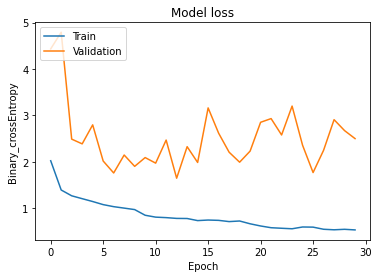

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

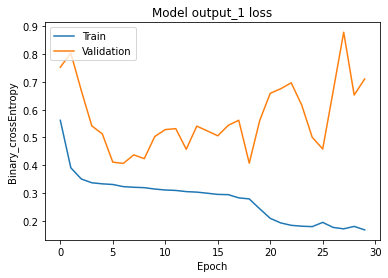

In [33]:
plt.plot(history.history['output_1_loss'])  
plt.plot(history.history['val_output_1_loss'])
plt.title('Model output_1 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

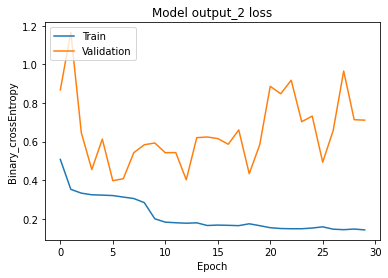

In [34]:
plt.plot(history.history['output_2_loss'])     
plt.plot(history.history['val_output_2_loss'])
plt.title('Model output_2 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

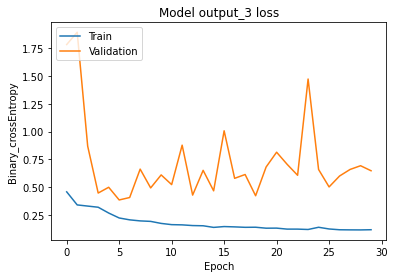

In [35]:
plt.plot(history.history['output_3_loss'])     
plt.plot(history.history['val_output_3_loss'])
plt.title('Model output_3 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

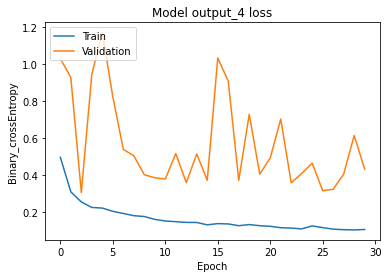

In [36]:
plt.plot(history.history['output_4_loss'])     
plt.plot(history.history['val_output_4_loss'])
plt.title('Model output_4 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

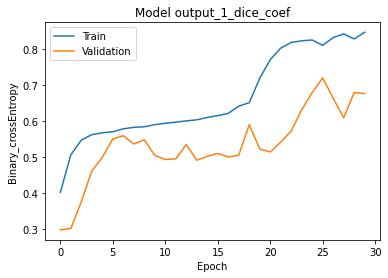

In [37]:
plt.plot(history.history['output_1_dice_coef'])         
plt.plot(history.history['val_output_1_dice_coef'])
plt.title('Model output_1_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

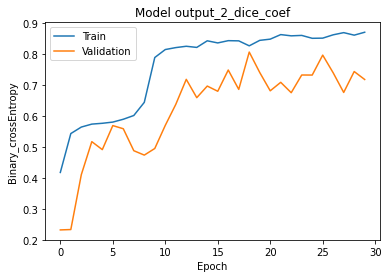

In [38]:
plt.plot(history.history['output_2_dice_coef'])     
plt.plot(history.history['val_output_2_dice_coef'])
plt.title('Model output_2_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

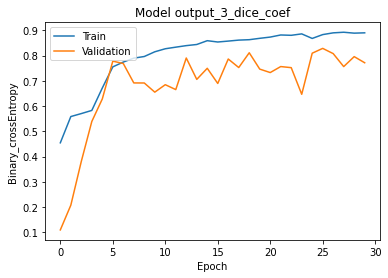

In [39]:
plt.plot(history.history['output_3_dice_coef'])     
plt.plot(history.history['val_output_3_dice_coef'])
plt.title('Model output_3_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

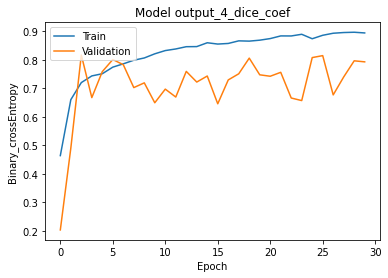

In [40]:
plt.plot(history.history['output_4_dice_coef'])         
plt.plot(history.history['val_output_4_dice_coef'])
plt.title('Model output_4_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

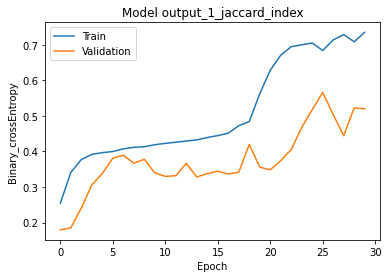

In [41]:
plt.plot(history.history['output_1_jaccard_index'])        ##########    
plt.plot(history.history['val_output_1_jaccard_index'])
plt.title('Model output_1_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

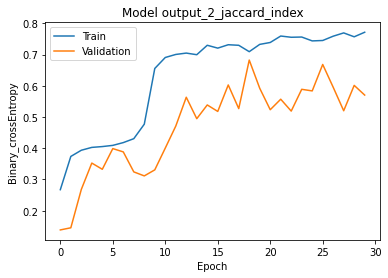

In [42]:
plt.plot(history.history['output_2_jaccard_index'])        ##########    
plt.plot(history.history['val_output_2_jaccard_index'])
plt.title('Model output_2_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

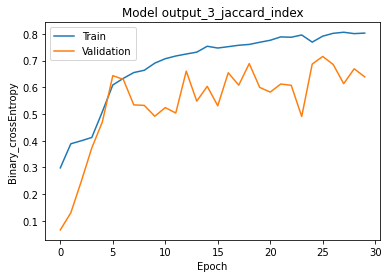

In [43]:
plt.plot(history.history['output_3_jaccard_index'])        ##########    
plt.plot(history.history['val_output_3_jaccard_index'])
plt.title('Model output_3_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

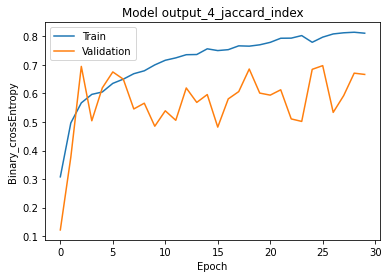

In [44]:
plt.plot(history.history['output_4_jaccard_index'])        ##########    
plt.plot(history.history['val_output_4_jaccard_index'])
plt.title('Model output_4_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()